In [12]:
#This notebook is for testing the download of PIPS data using the web API.
#It uses urllib3 and BeautifulSoup4
import bs4
import urllib3
import pandas as pd
import xarray as xr
import numpy as np
from pyPIPS.disdrometer_module import avg_diameter, fall_bins, eff_sensor_area, max_diameter, min_diameter

In [67]:


# Function definitions. These will eventually go into their own module
def scrape_tripips_onesec_data(url, numrecords=3600):
    """Grabs one-second records from the TriPIPS http server. Uses urlib3 and beautifulsoup4"""
    http = urllib3.PoolManager()
    content = http.request('GET', url + '&records={:d}'.format(numrecords))
    soup = bs4.BeautifulSoup(content.data, "lxml")
    table = soup.find('table')
    rows = table.find_all('tr')
    headers = rows.pop(0).find_all('th')
    headers.pop(0)
    headers = [header.string for header in headers]
    data = []
    timestamps = []
    for row in rows:
        tokens = row.find_all('td')
        tokens = [token.string.strip(' "') for token in tokens]
        timestamp = tokens.pop(0)
        tokens = [np.float(token) if token not in ('' or 'NAN') else np.nan for token in tokens]
        data.append(tokens)
        timestamps.append(timestamp)
    index = pd.to_datetime(timestamps, format='%Y-%m-%d %H:%M:%S')
    df = pd.DataFrame(data, columns=headers, index=index)
    return df

def scrape_tripips_tensec_data(url, numrecords=360):
    """Grabs ten-second records from the TriPIPS http server. Uses urlib3 and beautifulsoup4"""
    http = urllib3.PoolManager()
    content = http.request('GET', url + '&records={:d}'.format(numrecords))
    soup = bs4.BeautifulSoup(content.data, "lxml")
    table = soup.find('table')
    rows = table.find_all('tr')
    headers = rows.pop(0).find_all('th')
    headers.pop(0)
    headers = [header.string for header in headers]
    telegrams = []
    spectrum_list = []
    timestamps = []
    for row in rows:
        tokens = row.find_all('td')
        tokens = [token.string.strip(' "') for token in tokens]
        timestamp = tokens.pop(0)
        tokens.pop(0)
        parsivel_string = tokens.pop(0)
        telegram_dict = read_parsivel_telegram(parsivel_string)
        telegrams.append(telegram_dict)
        spectrum = read_parsivel_spectrum(parsivel_string)
        spectrum_list.append(spectrum)
        timestamps.append(timestamp)
        
    index = pd.to_datetime(timestamps, format='%Y-%m-%d %H:%M:%S')
    df_telegram = pd.DataFrame(telegrams, index=index)
    print(np.array(spectrum_list).shape)
    da_spectrum = xr.DataArray(spectrum_list, coords=[index, fall_bins,
                                                     avg_diameter],
                              dims=['time', 'velocity', 'diameter'])
    return df_telegram, da_spectrum
    
def read_parsivel_telegram(parsivel_string):
    """
    Reads the parsivel telegram and returns a dictionary for each component,
    except for the spectrum, which is handled separately by read_spectrum.
    """
    # print(parsivel_string)
    parsivel_tokens = parsivel_string.strip(' "').split(';')
    # print(parsivel_tokens)
    parsivel_tokens = parsivel_tokens[:11]
    
    
    parsivel_telegram_dict = {
        'parsivel_id': int(parsivel_tokens[0]),
        'rain rate (mm/hr)': float(parsivel_tokens[1]),
        'rain accumulation (mm)': float(parsivel_tokens[2]),
        'radar reflectivity (dBZ)': float(parsivel_tokens[3]),
        'sample interval': int(parsivel_tokens[4]),
        'signal amplitude': int(parsivel_tokens[5]),
        'particle count': int(parsivel_tokens[6]),
        'sensor temp': int(parsivel_tokens[7]),
        'power supply voltage': float(parsivel_tokens[8]),
        'sensor time': parsivel_tokens[9],
        'sensor date': parsivel_tokens[10]
    }
    
    return parsivel_telegram_dict

def read_parsivel_spectrum(parsivel_string):
    """Given a raw string of Parsivel data, extract the DSD spectrum from it."""
    parsivel_tokens = parsivel_string.strip(' "').split(';')
    #parsivel_tokens = parsivel_tokens.strip('"')
    spectrum = [float(x) if ('' or '\n' or '\r') not in x else 0 for x in parsivel_tokens[11:]]
    try:
        spectrum = [float(x) if ('' or '\n' or '\r') not in x else 0 for x in parsivel_tokens[11:]]
    except ValueError:
        spectrum = [-999 for i in range(1025)]
    # Strip off bogus final value (why is it there?)
    if len(spectrum) == 1025:
        spectrum = spectrum [:-1]
    # Reshape the spectrum to a 32x32 matrix of integers
    spectrum = np.array(spectrum, dtype='int')
    # Assert that the size of the array is what we expect
    # Otherwise generate a spectrum of missing values (-999)
    if(spectrum.size == 1024):
        spectrum = spectrum.reshape((32, 32))
    else:
        spectrum = -999 * np.ones((32, 32), dtype='int')
    return spectrum

def timestamp2datetime(timestamp):
    """Construct a datetime object from a timestamp of the form YYYY-MM-DD HH:MM:SS.XXX"""
    date, time = timestamp.strip().split()
    year = np.int(date[:4])
    month = np.int(date[5:7])
    day = np.int(date[8:])
    hour = np.int(time[:2])
    min = np.int(time[3:5])
    sec = np.int(time[6:8])
    
    return datetime(year, month, day, hour, min, sec)

def calc_ND_da(spectrum_da, interval=10, use_measured_fs=True):
    """Computes the number concentration from the 32x32 spectrum"""
    index = spectrum_da.coords['time'].values
    if not use_measured_fs:
        raise NotImplementedError('Not yet implemented: use measured fall speed for now!')
    else:
        ND_da = spectrum_da.groupby('time').apply(calc_ND)
    
    #ND_df = pd.DataFrame(ND_arr, columns=avg_diameter, index=index)
    return ND_da 

def calc_ND_list(spectrum_list, interval=10, use_measured_fs=True):
    ND_list = [calc_ND(spectrum, interval=DSD_interval) for spectrum in spectrum_list]
    ND_arr = np.array(ND_list)
    return ND_arr

def calc_ND(spectrum, interval=10, use_measured_fs=True):
    _, vspectrum = np.meshgrid(avg_diameter, fall_bins)
    dspectrum = spectrum
    if np.all(dspectrum == -999):
        print('Here!')
        ND = -999. * np.ones_like(avg_diameter)
        ND = np.ma.masked_where(ND == -999., ND)
    else:
        ND = dspectrum / (vspectrum * interval * eff_sensor_area * (max_diameter - min_diameter))
        if use_measured_fs:
            # ND = ND.sum(axis=0)
            ND = ND.sum(dim='velocity')
    return ND

In [72]:
numrecords = 3600
url_onesec = "http://10.163.29.26/?command=TableDisplay&table=One_Hz"
onesec_df = scrape_tripips_onesec_data(url_onesec, numrecords=numrecords)

Index([Record, BattV, PTemp_C, WindDir, WS_ms, WSDiag, SlowTemp, RH, Pressure,
       FluxDirection, GPSTime, GPSStatus, GPSLat, GPSLon, GPSSpd, GPSDir,
       GPSDate, GPSMagVar, GPSAlt, 'Dewpoint'],
      dtype='object')


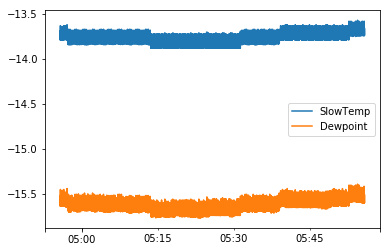

In [73]:
# Quick and dirty plot
from pyPIPS import thermolib as thermo
onesec_df['Dewpoint'] = thermo.calTdfromRH(onesec_df['Pressure'] * 100., onesec_df['SlowTemp'] + 273.15, 
                                     onesec_df['RH'] / 100.) - 273.15
print(onesec_df.columns)
onesec_df.plot(y=['SlowTemp', 'Dewpoint'])

In [78]:
numrecords = 360
url_tensec = "http://10.163.29.26/?command=TableDisplay&table=Ten_Hz"
telegram_df, spectrum_da = scrape_tripips_tensec_data(url_tensec, numrecords=numrecords)

(360, 32, 32)


In [79]:
print(telegram_df)

                     parsivel_id  particle count  power supply voltage  \
2019-02-01 04:58:30       390654               0                  11.9   
2019-02-01 04:58:40       390654               0                  11.8   
2019-02-01 04:58:50       390654               0                  11.8   
2019-02-01 04:59:00       390654               0                  11.8   
2019-02-01 04:59:10       390654              35                  11.8   
2019-02-01 04:59:20       390654               0                  11.8   
2019-02-01 04:59:30       390654              26                  11.8   
2019-02-01 04:59:40       390654               0                  11.8   
2019-02-01 04:59:50       390654               0                  11.9   
2019-02-01 05:00:00       390654               0                  11.8   
2019-02-01 05:00:10       390654               0                  11.8   
2019-02-01 05:00:20       390654               0                  11.8   
2019-02-01 05:00:30       390654      

In [76]:
ND_da = calc_ND_da(spectrum_da)
# ND_arr = calc_ND_list(spectrum_list)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
10
(32, 360)


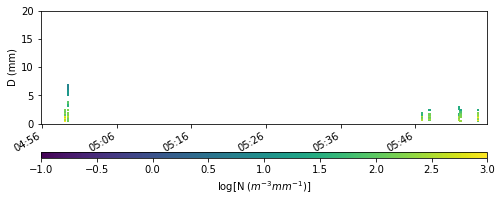

In [77]:
from datetime import datetime, timedelta
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from pyPIPS.plotmodule import plotDSDmeteograms
%load_ext autoreload
%autoreload 2

# print(timestamp_list)

# datetimelist = [timestamp2datetime(timestamp) for timestamp in timestamp_list]
# print(datetimelist)

# telegram_list = [read_parsivel_telegram(parsivel_string) for parsivel_string in ParsivelStr_list]
# spectrum_list = [read_spectrum(parsivel_string) for parsivel_string in ParsivelStr_list]

DSD_interval = telegram_df['sample interval'][0]
print(DSD_interval)
DSD_interval_td = timedelta(seconds=int(DSD_interval))
DSD_half_interval_td = timedelta(seconds=DSD_interval / 2.)
datetimelist = telegram_df.index.tolist()
datetimelist_edge = [x - DSD_interval_td for x in datetimelist]
datetimelist_middle = [x - DSD_half_interval_td for x in datetimelist]

# print(datetimelist_edge)
# ND_list = [calc_ND(spectrum, interval=DSD_interval) for spectrum in spectrum_list]
# ND_arr = np.array(ND_list)
# ND_arr = ND_arr.T
ND_arr = ND_da.values.T
logND_arr = np.ma.log10(ND_arr)
print(logND_arr.shape)


datetimesnums_edge = dates.date2num(datetimelist_edge)
datetimesnums_mid = dates.date2num(datetimelist_middle)

disvars =  {
    'min_diameter': min_diameter, 
    'PSDstarttimes': datetimesnums_edge,
    'PSDmidtimes': datetimesnums_mid, 
    'logND': logND_arr
}
radvars = {}
dateformat = '%H:%M'
axparams = {
    'majorxlocator': dates.MinuteLocator(interval=10), 
    'majorxformatter': dates.DateFormatter(dateformat),
    'minorxlocator': None,
    'axeslimits': [None, [0.0, 20.0]],
    'majorylocator': ticker.MultipleLocator(base=5.0),
    'axeslabels': [None, 'D (mm)']
}

plotDSDmeteograms('TriPIPS', './', axparams, disvars, radvars, close_fig=False)

In [ ]:
DSD_interval = np.int(ParsivelStr[0])
PSDstarttimes = 

In [ ]:
filepath = filelist[0]
http = urllib3.PoolManager()
url = "http://10.163.29.26/"+filepath
content = http.request('GET',url)
download = content.data
with open(output_dir+path,'wb') as output:
  output.write(download)

In [ ]:
lastfilenum = 11998
filelist = filelist[lastfilenum:]
output_dir = '/Users/dawson29/Dropbox/Projects/TriPIPS/incoming_121418_011219/'
http = urllib3.PoolManager()
for i,filepath in enumerate(filelist):
    print("Downloading file #{0}, name: {1}".format(i,filepath))
    drive,path = os.path.split(filepath)
    url = "http://10.163.29.26/"+filepath
    content = http.request('GET',url)
    download = content.data
    with open(output_dir+path,'wb') as output:
        output.write(download)

In [ ]:
8115+1230

In [ ]:
6*24

In [ ]:
60*6